In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.91it/s]


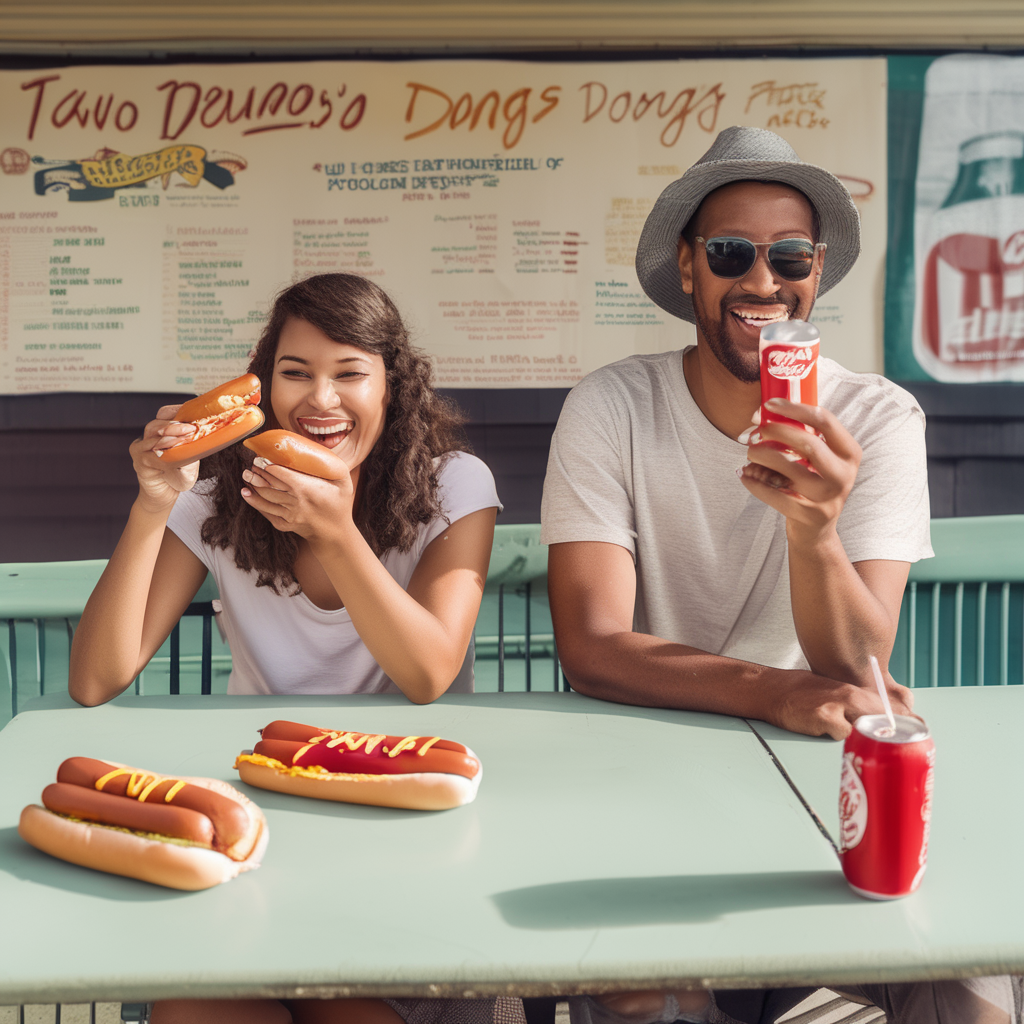

In [6]:
out.images[0]

In [7]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.
"""

In [8]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xxl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xxl") 
model.eval()
model.to("cuda:0")

Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [9]:
responses = []
images = []
for i, prompt in enumerate(prompts):
    query = f"={instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"
    generator = torch.Generator(device=device1).manual_seed(SEED)
    out = base(prompt=[prompt]*N_IMG, num_inference_steps=300, generator=generator, latents=None)
    out.images[0].save(f"../samples/img{i}.png","PNG")
    images.append(out.images[0])

    inputs = processor(out.images[0], query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

100%|██████████| 300/300 [00:38<00:00,  7.87it/s]


In [10]:
for response in responses:
    print(response)
    print("--------")

<pad> tuple(object type, people) tuple(object type, hot dogs) tuple(object type, soda pop)</s>
--------
<pad> tuple(people), tuple(umbrella), tuple(benches, motorcycle)</s>
--------
<pad> tuple(object type), tuple(s)</s>
--------
<pad> tuple(object type, surfer) tuple(surfer, wave)</s>
--------
<pad> tuple(object type,'surfboard')</s>
--------


### As we can see the model's response makes no sense

## Try to add examples of response

In [11]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of response:

- Example 1
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [14]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [15]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella','motorcycle', 'bench']</s>
--------
<pad> [['woman', 'top', 'blue'], ['surfboards', 'two']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['surfboard','man']]</s>
--------


### The results became significantly better, but the format is not correct.

## Try to add the original prompt to examples

In [16]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]
"""

In [20]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [21]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'benches','motorcycle']]</s>
--------
<pad> [['woman', 'top', 'blue'], ['surfboards', 'two']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


### As we can see, it did not change the results significantly

## Try to add more examples

In [22]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]
"""

In [24]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


In [25]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'bench','motorcycle']</s>
--------
<pad> [['woman', 'top', 'blue'], ['surfboards', 'two']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


### Results have not changed

## Maybe more examples?

In [26]:
instruction = """# Your Role: Excellent Parser

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image.
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      
"""

In [28]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [29]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs'],'soda pop']</s>
--------
<pad> [['people', 'umbrella', 'bench','motorcycle']]</s>
--------
<pad> [['woman', 'top', 'blue'],'surfboards', 'two']</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


### Then qualirty of results has not changed

## The same, but instructions go after the examples

In [30]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [32]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [33]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'benches','motorcycle']]</s>
--------
<pad> [['woman', 'top', 'blue'], ['surfboards', 'two']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['surfboard','man']]</s>
--------


In [34]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [35]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [36]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'bench','motorcycle']]</s>
--------
<pad> [['woman', 'top', 'blue'], ['surfboards', 'two']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['surfboard','man']]</s>
--------


In [37]:
instruction = """# Your Role: Excellent Parser

Examples of prompt and the expected response:

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.                                                                                                                            
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]   

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.                                                                   
"""

In [41]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [42]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs'],'soda pop']</s>
--------
<pad> [['people', 'umbrella', 'benches','motorcycle']]</s>
--------
<pad> [['woman', 'top', 'blue'],'surfboards', 'two']</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['surfboard','man']]</s>
--------


### The response still does not satisfy the required format

## Chain-of-thought prompting

In [43]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [46]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [47]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'benches','motorcycle']]</s>
--------
<pad> [['woman', 'top','surfboards']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


In [48]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
As a response I expect the list of tuples. The first element of each tuple is the object type, the second is the list of strings. The length of the list represents the number of objects of that type, each element represent the attributes for corresponding object. If the attribute for a specifc object is not mentioned in the prompt, write the attribute as None. Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.          
"""

In [50]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [51]:
for response in responses:
    print(response)
    print("--------")

<pad> tuple('people', 'hot dogs','soda pop')</s>
--------
<pad> tuple('People', 'umbrella', 'Benches', 'Motorcycle')</s>
--------
<pad> tuple('woman', 'top', 'blue','surfboards')</s>
--------
<pad> tuple('surfer', 'wave')</s>
--------
<pad> tuple('surfboard','man', 'beach','surfboard')</s>
--------


In [52]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [53]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [54]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'bench','motorcycle']]</s>
--------
<pad> [['woman', 'top','surfboards']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


In [55]:
instruction = """# Your Role: Excellent Parser

## Objective: Analyze scene and scene descriptions to identify objects and their attributes.

## Process Steps
1. Analyze the image.
2. Read the user prompt (scene description).
3. Identify all objects presented in the image and mentioned with quantities.
4. Extract attributes of each object (color, size, material, etc.).
5. If the description mentions objects that shouldn't be in the image, take note at the negation part.
6. Explain your understanding (reasoning) and then format your result (answer / negation) as shown in the examples.
7. Importance of Extracting Attributes: Attributes provide specific details about the objects. This helps differentiate between similar objects and gives a clearer understanding of the scene.

## Examples of prompt and resonse

- Example 1
    User prompt: A brown horse is beneath a black dog. Another orange cat is beneath a brown horse.
    Reasoning: The description talks about three objects: a brown horse, a black dog, and an orange cat. We report the color attribute thoroughly. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('horse', ['brown']), ('dog', ['black']), ('cat', ['orange'])]

- Example 2
    User prompt: There's a white car and a yellow airplane in a garage. They're in front of two dogs and behind a cat. The car is small. Another yellow car is outside the garage.
    Reasoning: The scene has two cars, one airplane, two dogs, and a cat. The car and airplane have colors. The first car also has a size. No specified negation terms. The background is a garage.
    Objects: [('car', ['white and small', 'yellow']), ('airplane', ['yellow']), ('dog', [None, None]), ('cat', [None])]

- Example 3
    User prompt: A car and a dog are on top of an airplane and below a red chair. There's another dog sitting on the mentioned chair.
    Reasoning: Four objects are described: one car, airplane, two dog, and a chair. The chair is red color. No specified negation terms. No background is mentioned and thus fill in the default one.
    Objects: [('car', [None]), ('airplane', [None]), ('dog', [None, None]), ('chair', ['red'])]

- Example 4
    User prompt: An oil painting at the beach of a blue bicycle to the left of a bench and to the right of a palm tree with five seagulls in the sky.
    Reasoning: Here, there are five seagulls, one blue bicycle, one palm tree, and one bench. No specified negation terms. The background is an oil painting at the beach.
    Objects: [('bicycle', ['blue']), ('palm tree', [None]), ('seagull', [None, None, None, None, None]), ('bench', [None])]

- Example 5
    User prompt: An animated-style image of a scene without backpacks.
    Reasoning: The description clearly states no backpacks, so this must be acknowledged. The user provides the negative prompt of backpacks. The background is an animated-style image.
    Objects: [('backpacks', [None])]

- Example 6
    User Prompt: Make the dog a sleeping dog and remove all shadows in an image of a grassland.
    Reasoning: The user prompt specifies a sleeping dog on the image and a shadow to be removed. The background is a realistic image of a grassland.                                                                                                                              
    Objects: [('dog', ['sleeping']), ['shadow', [None]]]                                                                                                      

Your Current Task: Analyze scene and scene descriptions to identify objects and their attributes mentioned in the prompt and presented in the image. 
Ensure that all object types and object attributes are presented in the image and mentioned in the prompt.            
"""

In [56]:
responses = []
for image, prompt in zip(images, prompts):
    query = f"{instruction}\n\nImage: <image>\nUser Prompt: {prompt}\n"

    inputs = processor(image, query, return_tensors="pt").to("cuda:0")

    # autoregressively complete prompt
    output = model.generate(**inputs, max_new_tokens=1024, temperature=0.0)

    responses.append(processor.decode(output[0]))

In [57]:
for response in responses:
    print(response)
    print("--------")

<pad> [['people', 'hot dogs','soda pop']]</s>
--------
<pad> [['people', 'umbrella', 'benches','motorcycle']]</s>
--------
<pad> [['woman', 'top','surfboards']]</s>
--------
<pad> [['surfer', 'wave']]</s>
--------
<pad> [['man','surfboard']]</s>
--------


## Still, the model could not manage to give the response in the required format

# Conclusion: BLIP-2 model has shown the worst performance among three analyzed multimodal LLMs. Proably, such complex tasks is not what these open source LMMs were trained on.